# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape, feat_info.shape

((891221, 85), (85, 4))

In [4]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
# Checking the unique values in information_level.
feat_info['information_level'].unique()

array(['person', 'household', 'building', 'microcell_rr4', 'microcell_rr3',
       'postcode', 'region_rr1', 'macrocell_plz8', 'community'], dtype=object)

In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Strip [] from missing_or_unknown and split by ','
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[]').split(','))

# Loop through feat_info attribute and missing_or_unknown to find lists with numbers.
for attribute, missing_or_unknown in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_or_unknown[0] != '':
        # Loop through lists that have entries.
        for val in missing_or_unknown:
            # Test that entry is positive or negative numeric and replace as np.nan.
            if val.isnumeric() or val.lstrip('-').isnumeric():
                azdias.loc[azdias[attribute] == int(val), attribute] = np.nan
            else:
                azdias.loc[azdias[attribute] == val, attribute] = np.nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

# Test and Delete without this

# Using missing_or_unknown columns in feat_info to clean azdias features.
for x, y in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if y[0] != '':
        for val in y:
            if val.isnumeric() or val.lstrip('-').isnumeric():
                azdias.loc[azdias[x] == int(val), x] = np.nan
            else:
                azdias.loc[azdias[x] == val, x] = np.nan

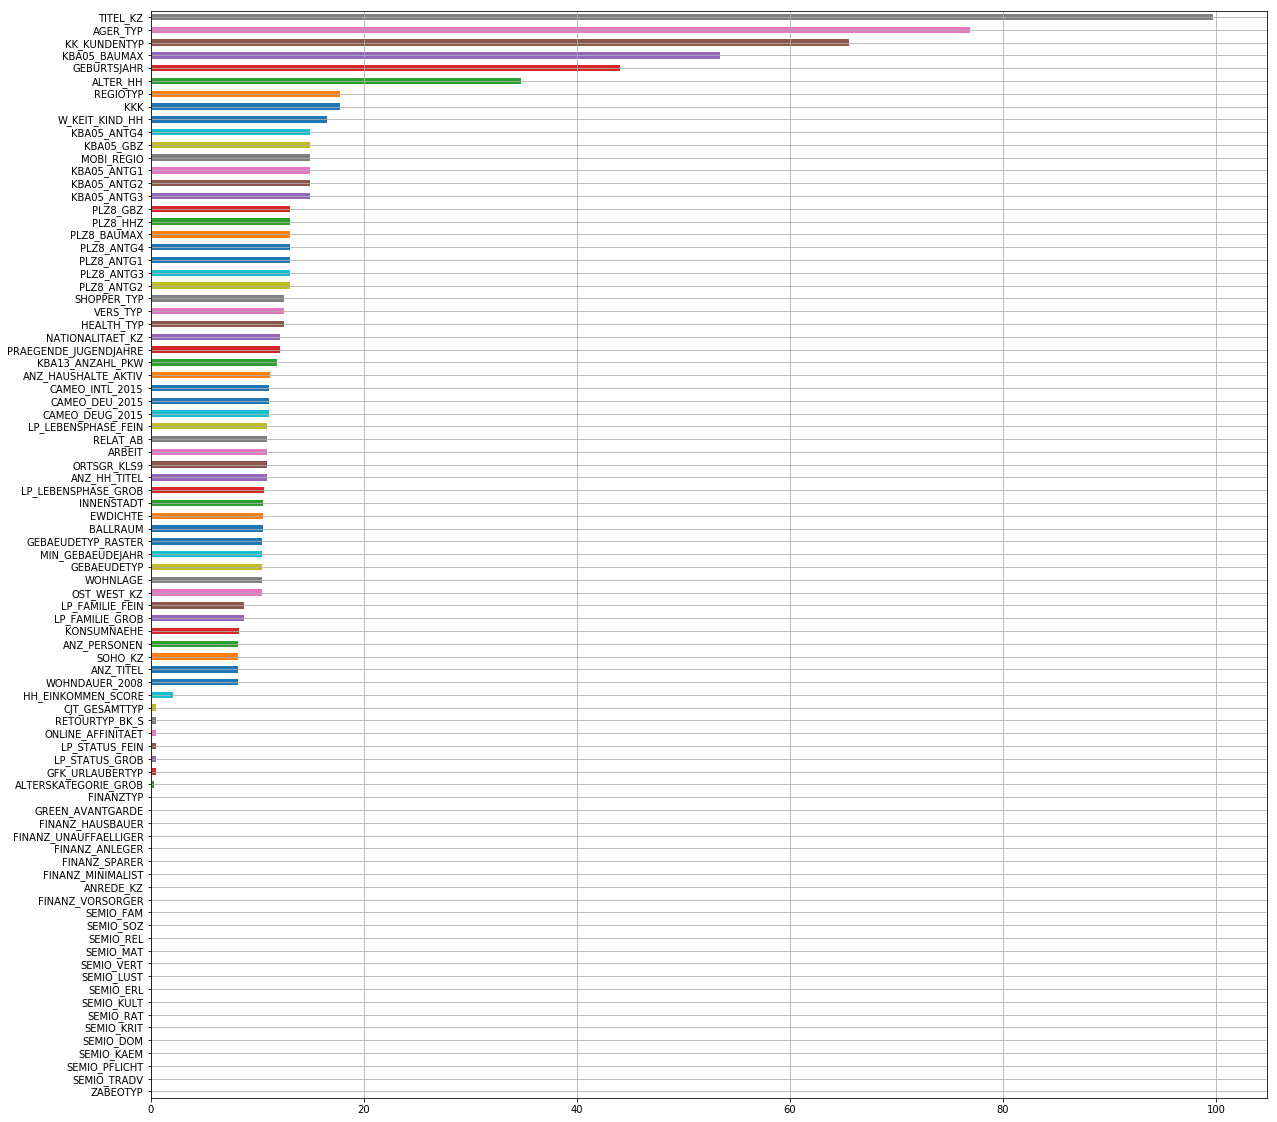

In [9]:
# Barchart to show percentage of each column that is np.nan.
azdias.isnull().sum().mul(100).div(len(azdias)).sort_values().plot(kind='barh', figsize=(20, 20), grid=True)

> Visually, there are six features that have a large percentage of nulls in their data. Each outlier feature seems to be greater than 30% nulls.

In [10]:
# Looking at the head of the data above, which confirms all values are over 30%.
azdias.isnull().sum().mul(100).div(len(azdias)).sort_values(ascending=False).head(6)

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64

In [11]:
# Checking feat_info to see if outlier features have a common information level.
feat_info[feat_info['attribute'].isin(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'])]

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
11,GEBURTSJAHR,person,numeric,[0]
40,TITEL_KZ,person,categorical,"[-1, 0]"
43,ALTER_HH,household,interval,[0]
47,KK_KUNDENTYP,household,categorical,[-1]
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"


In [12]:
# Drop all features that have a null percentage above 30%.
perc = 30.0
min_count = int(((100 - perc) / 100) * azdias.shape[0] + 1)
azdias = azdias.dropna(axis=1, thresh=min_count)

In [13]:
# Confirm that appropiate columns were dropped.
azdias.isnull().sum().mul(100).div(len(azdias)).sort_values(ascending=False).head(6)

KKK               17.735668
REGIOTYP          17.735668
W_KEIT_KIND_HH    16.605084
MOBI_REGIO        14.959701
KBA05_ANTG4       14.959701
KBA05_ANTG3       14.959701
dtype: float64

#### Discussion 1.1.2: Assess Missing Data in Each Column

I started by visually analyzing each column with a horizontal bar chart that displayed the sorted percentage of nulls that each column had. Visually, there were obviously six outlier features, TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH. I estimated from the chart that these six columns consisted of above 30% null values.

After looking at the data for this chart, I determined that they are indeed above 30% with the lowest of the top 6 being 34.81%. I checked to see if the features were of the same information level, but they are not. The top three features were person level, the next two were household, and the last one is microcell_rr3. I then proceeded to drop these columns programmaticaly based on dropping any feature that had above 30% null values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
azdias.head(1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# How much data is missing in each row of the dataset?
azdias.isnull().sum(axis=1).describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

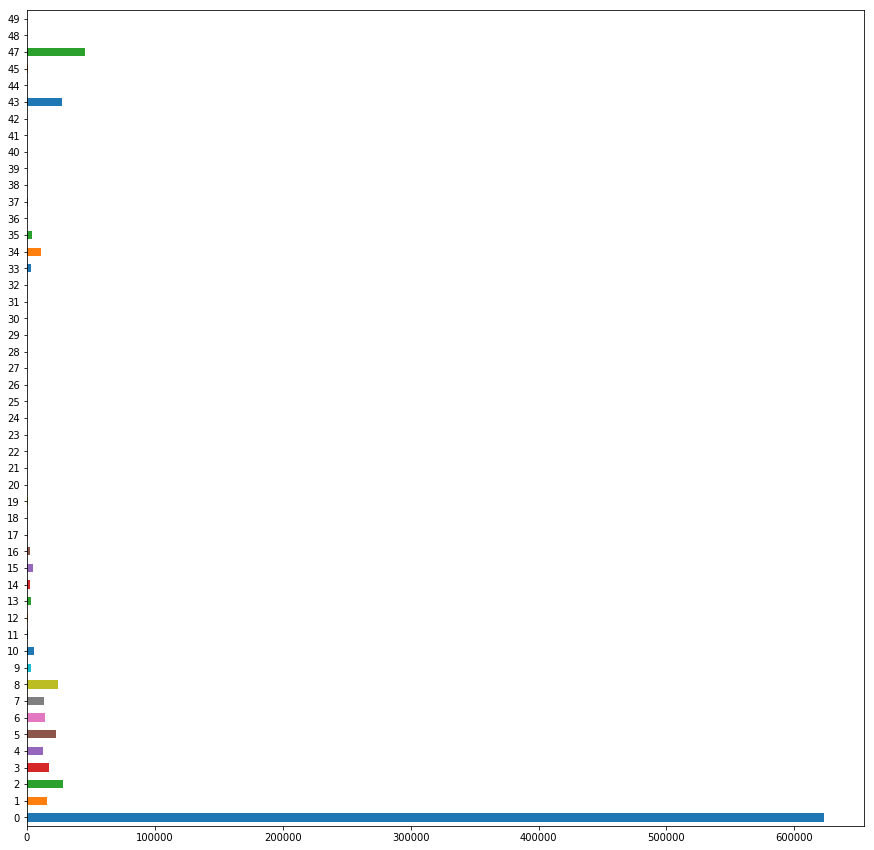

In [16]:
# Check  the value_counts of nuls to look for trend.
azdias.isnull().sum(axis=1).value_counts().sort_index().plot(kind='barh', figsize=(15, 15))

> Although the mean for missing features per row is 5.6, this is being pulled down by the high count of rows that are missing 0 features. Visually, it looks like after 10, the count drops significantly. I believe this is a good split for the DataFrame split.

In [17]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
# After visual analysis above, I'm making the educated guess to split on <= 10 and > 10
azdias_ten_under = azdias[azdias.isnull().sum(axis=1) <= 10]
azdias_morethan_ten = azdias[azdias.isnull().sum(axis=1) > 10]


In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Looking at top 50 features with minimal nulls. Will pick random features for distribution comparison.
azdias.isnull().sum().mul(100).div(len(azdias)).sort_values().head(50)

ZABEOTYP                  0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT                0.000000
SEMIO_LUST                0.000000
SEMIO_ERL                 0.000000
SEMIO_KULT                0.000000
SEMIO_RAT                 0.000000
SEMIO_KRIT                0.000000
SEMIO_DOM                 0.000000
SEMIO_KAEM                0.000000
GREEN_AVANTGARDE          0.000000
SEMIO_PFLICHT             0.000000
FINANZTYP                 0.000000
FINANZ_HAUSBAUER          0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_ANLEGER            0.000000
FINANZ_VORSORGER          0.000000
FINANZ_SPARER             0.000000
FINANZ_MINIMALIST         0.000000
SEMIO_TRADV               0.000000
ANREDE_KZ                 0.000000
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
ALTERSKATEGORIE_GROB      0.323264
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
ONLINE_AFFINITAET         0.544646
RETOURTYP_BK_S      

In [19]:
def compare_spread(df1, df2, feature, df1_title = 'DF1 Title', df2_title = 'DF2 Title'):
    '''
        Presents two sns.countplots side-by-side for comparing a shared feature.
    '''
    fig, ax = plt.subplots(2, 2, figsize=(10, 7))
    plt.subplot(1,2,1)
    plt.title(df1_title)
    sns.countplot(x=feature, data=df1)
    
    plt.subplot(1,2,2)
    plt.title(df2_title)
    sns.countplot(x=feature, data=df2)
    
# Random Testing Features
testing_features = ['ZABEOTYP', 'SEMIO_REL', 'ANREDE_KZ', 'ALTERSKATEGORIE_GROB', 'LP_STATUS_GROB']

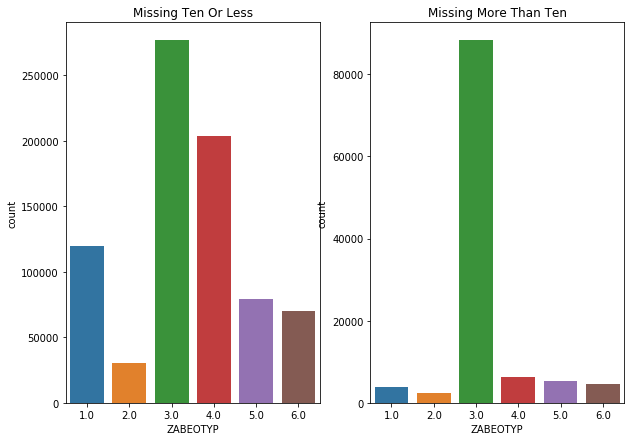

In [20]:
# Spread comparison for ZABEOTYP
compare_spread(azdias_ten_under, azdias_morethan_ten, testing_features[0], df1_title='Missing Ten Or Less', df2_title='Missing More Than Ten')

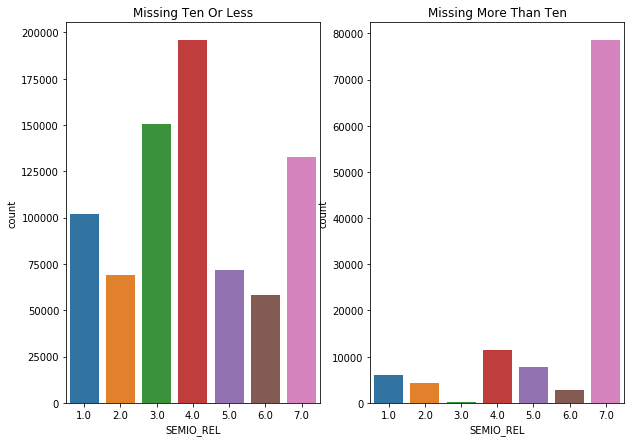

In [21]:
# Spread comparison for SEMIO_REL
compare_spread(azdias_ten_under, azdias_morethan_ten, testing_features[1], df1_title='Missing Ten Or Less', df2_title='Missing More Than Ten')

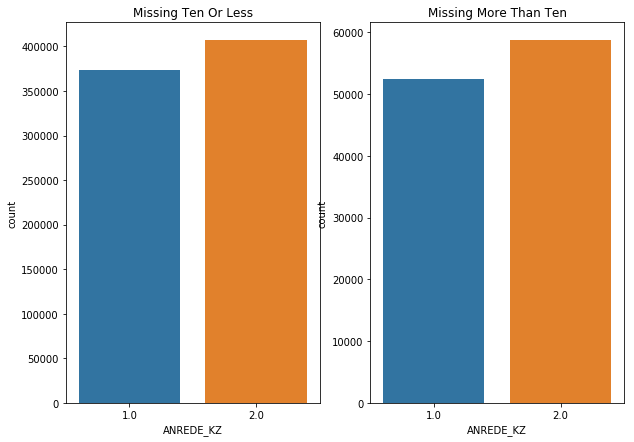

In [22]:
# Spread comparison for ANREDE_KZ
compare_spread(azdias_ten_under, azdias_morethan_ten, testing_features[2], df1_title='Missing Ten Or Less', df2_title='Missing More Than Ten')

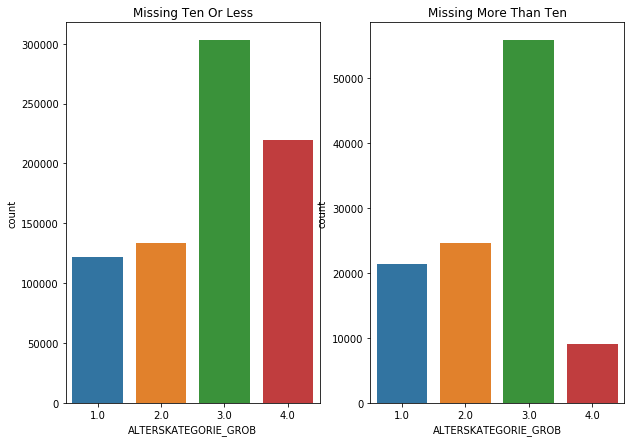

In [23]:
# Spread comparison for ALTERSKATEGORIE_GROB
compare_spread(azdias_ten_under, azdias_morethan_ten, testing_features[3], df1_title='Missing Ten Or Less', df2_title='Missing More Than Ten')

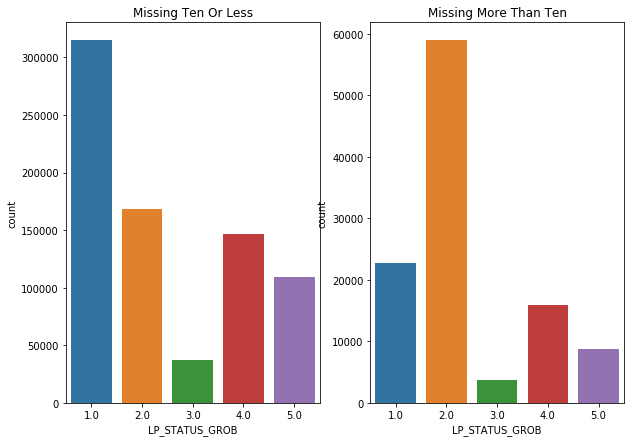

In [24]:
# Spread comparison for LP_STATUS_GROB
compare_spread(azdias_ten_under, azdias_morethan_ten, testing_features[4], df1_title='Missing Ten Or Less', df2_title='Missing More Than Ten')

#### Discussion 1.1.3: Assess Missing Data in Each Row

I started off by looking at df.describe() on a sum of missing features per row. This gave me the min, max, and mean of missing features. I found that the average of missing features is 5.6 with a low of 0 and a high of 48. Next, I produced a sorted horizontal bar chart based on the value_counts() of null features per row. This allowed me to visually see that most observations are missing ten features or less. The bulk of our dataset, 600,000+ observations, are missing zero features. I made the decision to split the rows at <= ten and > ten based on the graph.

I programmatically split the data into two separate DataFrames, azdias_ten_under and azdias_morethan_ten. Lastly, I picked five random features based on a query of the top 50 features with the lowest missing values. I created a function to visually compare these features and displayed each one separately. Although two of the five features slightly shared a similar distribution, there is definitely a different between the two DataFrames.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
feat_info[feat_info['type'] == 'categorical']['attribute']

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [27]:
# This code block was used to check all value_counts() individually. 
# This repetition was used to build the table below.
azdias_ten_under['OST_WEST_KZ'].value_counts()

W    614719
O    165434
Name: OST_WEST_KZ, dtype: int64

> The table below was built by running the previous code block multiple times in order to inspect each feature. 

| Feature          | Type                      | Description                                      | To-Do            |
|------------------|---------------------------|--------------------------------------------------|------------------|
| AGER_TYP         | ***already removed***     | ***already removed***                            | No Work Required |
| ANREDE_KZ        | Binary Numerical          | No Work Required                                 | No Work Required |
| CJT_GESAMTTYP    | Multi-Level Numerical     | Preferred information and buying channels        | OneHotEncoder    |
| FINANZTYP        | Multi-Level Numerical     | Descriptive financial type                       | OneHotEncoder    |
| GFK_URLAUBERTYP  | Multi-Level Numerical     | Vacation habits                                  | OneHotEncoder    |
| GREEN_AVANTGARDE | Binary Numerical          | Environmental sustainability membership in youth | No Work Required |
| LP_FAMILIE_FEIN  | Multi-Level Numerical     | Family Type - Fine Scale                         | OneHotEncoder    |
| LP_FAMILIE_GROB  | Multi-Level Numerical     | Family Type - Rough Scale                        | Drop Feature     |
| LP_STATUS_FEIN   | Multi-Level Numerical     | Social Status - Fine Scale                       | OneHotEncoder    |
| LP_STATUS_GROB   | Multi-Level Numerical     | Social Status - Rough Scale                      | Drop Feature     |
| NATIONALITAET_KZ | Multi-Level Numerical     | Nationality based on given name                  | Drop Feature     |
| SHOPPER_TYP      | Multi-Level Numerical     | Shopper Type                                     | OneHotEncoder    |
| SOHO_KZ          | Binary Numerical          | Small Office / Home Office                       | No Work Required |
| TITEL_KZ         | ***already removed***     | ***already removed***                            | No Work Required |
| VERS_TYP         | Binary Numerical          | Insurance Typology                               | No Work Required |
| ZABEOTYP         | Multi-Level Numerical     | Energy Consumption Typology                      | Drop Feature     |
| KK_KUNDENTYP     | ***already removed***     | ***already removed***                            | No Work Required |
| GEBAEUDETYP      | Multi-Level Numerical     | Type of Building                                 | Drop Feature     |
| OST_WEST_KZ      | Binary Using Alpha (W/O)  | Building Location East/West                      | Convert to int   |
| CAMEO_DEUG_2015  | Multi-Level Numerical     | German Cameo: Wealth / Life Stage                | OneHotEncoder    |
| CAMEO_DEU_2015   | Multi-Level Numeric/Alpha | German Cameo: Wealth / Life Stage                | Drop Feature     |

> 

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Create a list of features that were determined to be dropped. Drop with df.drop()
features_to_drop = ['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEU_2015']
features_for_onehot = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'SHOPPER_TYP', 'CAMEO_DEUG_2015']

In [29]:
# Confirm value_counts() of OST_WEST_KZ prior to conversion.
azdias_ten_under['OST_WEST_KZ'].value_counts()

W    614719
O    165434
Name: OST_WEST_KZ, dtype: int64

In [30]:
# Convert OST_WEST_KZ from alpha binary to numeric binary
# W = 1, O = E
# 1 = West Germany, 0 = East Germany
azdias_ten_under['OST_WEST_KZ'].replace('W', 1, inplace=True)
azdias_ten_under['OST_WEST_KZ'].replace('O', 0, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [31]:
# Confirm value_counts() of OST_WEST_KZ after the conversion.
azdias_ten_under['OST_WEST_KZ'].value_counts()

1    614719
0    165434
Name: OST_WEST_KZ, dtype: int64

In [32]:
# Drop features that were previously decided to be dropped. 
azdias_ten_under.drop(features_to_drop, axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [33]:
# Check that features were dropped.
azdias_ten_under.shape

(780153, 73)

In [34]:
# OneHotEncoding via pd.get_dummies()
azdias_recoded = azdias_ten_under.copy()
azdias_recoded = pd.get_dummies(data=azdias_recoded, columns=features_for_onehot)

In [35]:
# Check shape after OneHotEncoding
azdias_recoded.shape

(780153, 124)

#### Discussion 1.2.1: Re-Encode Categorical Features

I started by finding all of the categorical features listed in feat_info. Afterward, I used a single code block iteratively to investigate each feature’s value_counts() in the azdias dataframe. I used this information to build a table for each feature with the feature name, type (binary numerical, multi-level numerical, ect…), description (retrieved from Data_Dictionary.md), and what I wanted to do. Some of the features were already removed from in previous sections. I went through each feature and decided to one hot encode eight features and drop six features. The decision to drop those features were based on them being *almost* duplicates (rough/fine) and lack of interest in the feature. After building this table, I used it as a guide for the following tasks.

I proceeded to build two Python lists. The first one was track which features I wanted to drop. The second one was to track which features I decided to one hot encode. Additionally, I found that although OST_WEST_KZ was already binary, it was listed as alpha, not numerical. I confirmed this with value_counts(), converted W to 1 and O to 0, and confirmed that the values changed afterward. I then performed a df.drop() using the list I previously created. I created a copy of azdias named azdias_recoded and proceeded to one hot encode the features I previously determined to be necessary. For this I used pd.get_dummies().


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [36]:
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [37]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_recoded['PRAEGENDE_JUGENDJAHRE'].value_counts().sort_index()

1.0      20242
2.0       7438
3.0      53098
4.0      20343
5.0      83645
6.0      25517
7.0       3964
8.0     138678
9.0      33197
10.0     83881
11.0     34642
12.0     24034
13.0      5561
14.0    178410
15.0     41029
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

> Based on the information from Data_Dictionary.md on PRAEGENDE_JUGENDJAHRE, I will create two new features; PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT.

In [38]:
# Create a dictionary to that will be used to map the decade from 
# PRAEGENDE_JUGENDJAHRE to PRAEGENDE_JUGENDJAHRE_DECADE
decade_dict = {
    1.0: 1, # 40s
    2.0: 1, # 40s
    3.0: 2, # 50s
    4.0: 2, # 50s
    5.0: 3, # 60s
    6.0: 3, # 60s
    7.0: 3, # 60s
    8.0: 4, # 70s
    9.0: 4, # 70s
    10.0: 5, # 80s
    11.0: 5, # 80s
    12.0: 5, # 80s
    13.0: 5, # 80s
    14.0: 6, # 90s
    15.0: 6 # 90s
}

azdias_recoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_recoded['PRAEGENDE_JUGENDJAHRE'].replace(decade_dict)

In [39]:
# Check value_counts() of newly created feature.
azdias_recoded['PRAEGENDE_JUGENDJAHRE_DECADE'].value_counts()

6.0    219439
4.0    171875
5.0    148118
3.0    113126
2.0     73441
1.0     27680
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64

In [40]:
# One hot encode PRAEGENDE_JUGENDJAHRE_DECADE and drop PRAEGENDE_JUGENDJAHRE
azdias_recoded = pd.get_dummies(data=azdias_recoded, columns=['PRAEGENDE_JUGENDJAHRE_DECADE'])

In [41]:
# Confirm one hot encoding worked and that the origin
azdias_recoded.shape

(780153, 130)

> Now that the new feature has been created, I will perform the same engineering steps for PRAEGENDE_JUGENDJAHRE_MOVEMENT

In [42]:
# Create a dictionary to that will be used to map the decade from 
# PRAEGENDE_JUGENDJAHRE to PRAEGENDE_JUGENDJAHRE_MOVEMENT
# Mainstream = 1, Avantgarde = 0

movement_dict = {
    1.0: 1, # Mainstream
    2.0: 0, # Avantgarde
    3.0: 1, # Mainstream
    4.0: 0, # Avantgarde
    5.0: 1, # Mainstream
    6.0: 0, # Avantgarde
    7.0: 0, # Avantgarde
    8.0: 1, # Mainstream
    9.0: 0, # Avantgarde
    10.0: 1, # Mainstream
    11.0: 0, # Avantgarde
    12.0: 1, # Mainstream
    13.0: 0, # Avantgarde
    14.0: 1, # Mainstream
    15.0: 0 # Avantgarde
}

azdias_recoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_recoded['PRAEGENDE_JUGENDJAHRE'].replace(movement_dict)

In [43]:
azdias_recoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].value_counts()

1.0    581988
0.0    171691
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64

In [44]:
# Now that both features were created, I drop the original
azdias_recoded.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

Based on the information from Data_Dictionary.md on CAMEO_INTL_2015, I will create two new features; CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_FAMILY.

In [45]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_recoded['CAMEO_INTL_2015'].value_counts().sort_index()

12     12890
13     25659
14     61422
15     16735
22     32235
23     24280
24     89200
25     38860
31     17853
32     10153
33      9636
34     18237
35     10212
41     91071
43     55836
44     14593
45     25771
51    132853
52     20388
54     45004
55     23609
Name: CAMEO_INTL_2015, dtype: int64

In [46]:
# Create a dictionary that will be used to with df.replace() to create the new feature.
wealth_dict = {
    '12': 1, # Wealthy
    '13': 1, # Wealthy
    '14': 1, # Wealthy
    '15': 1, # Wealthy
    '22': 2, # Prosperous
    '23': 2, # Prosperous
    '24': 2, # Prosperous
    '25': 2, # Prosperous
    '31': 3, # Comfortable
    '32': 3, # Comfortable
    '33': 3, # Comfortable
    '34': 3, # Comfortable
    '35': 3, # Comfortable
    '41': 4, # Less Affluent Households
    '43': 4, # Less Affluent Households
    '44': 4, # Less Affluent Households
    '45': 4, # Less Affluent Households
    '51': 5, # Poorer Households
    '52': 5, # Poorer Households
    '54': 5, # Poorer Households
    '55': 5  # Poorer Households
}

azdias_recoded['CAMEO_INTL_2015_WEALTH'] = azdias_recoded['CAMEO_INTL_2015'].replace(wealth_dict)

In [47]:
# Check value_counts() on new feature.
azdias_recoded['CAMEO_INTL_2015_WEALTH'].value_counts()

5.0    221854
4.0    187271
2.0    184575
1.0    116706
3.0     66091
Name: CAMEO_INTL_2015_WEALTH, dtype: int64

In [48]:
# One hot encoding to get dummies for new feature.
azdias_recoded = pd.get_dummies(data=azdias_recoded, columns=['CAMEO_INTL_2015_WEALTH'])

In [49]:
# Confirm dummies were added.
azdias_recoded.shape

(780153, 135)

> Now that the new feature has been created, I will perform the same engineering steps for CAMEO_INTL_2015_FAMILY

In [50]:
# Create a dictionary that will be used to with df.replace() to create the new feature.
family_dict = {
    '12': 2, # Young Couples With Children
    '13': 3, # Families With School Age Children
    '14': 4, # Older Families &  Mature Couples
    '15': 5, # Elders In Retirement
    '22': 2, # Young Couples With Children
    '23': 3, # Families With School Age Children
    '24': 4, # Older Families &  Mature Couples
    '25': 5, # Elders In Retirement
    '31': 1, # Pre-Family Couples & Singles
    '32': 2, # Young Couples With Children
    '33': 3, # Families With School Age Children
    '34': 4, # Older Families &  Mature Couples
    '35': 5, # Elders In Retirement
    '41': 1, # Pre-Family Couples & Singles
    '43': 3, # Families With School Age Children
    '44': 4, # Older Families &  Mature Couples
    '45': 5, # Elders In Retirement
    '51': 1, # Pre-Family Couples & Singles
    '52': 2, # Young Couples With Children
    '54': 4, # Older Families &  Mature Couples
    '55': 5, # Elders In Retirement
}

azdias_recoded['CAMEO_INTL_2015_FAMILY'] = azdias_recoded['CAMEO_INTL_2015'].replace(family_dict)

In [51]:
# Check value_counts() on new feature.
azdias_recoded['CAMEO_INTL_2015_FAMILY'].value_counts()

1.0    241777
4.0    228456
3.0    115411
5.0    115187
2.0     75666
Name: CAMEO_INTL_2015_FAMILY, dtype: int64

In [52]:
# One hot encoding to get dummies for new feature.
azdias_recoded = pd.get_dummies(data=azdias_recoded, columns=['CAMEO_INTL_2015_FAMILY'])

In [53]:
# Confirm dummies were added.
azdias_recoded.shape

(780153, 140)

In [54]:
# Drop CAMEO_INTL_2015
azdias_recoded.drop('CAMEO_INTL_2015', axis=1, inplace=True)

> Now that I'm finished with the feature engineer involving PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, I will remove the other mixed features.

In [55]:
# Remove the rest of the mixed features that are not being used.
# KBA05_BAUMAX was removed during preprocessing.
mixed_features_to_remove = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
azdias_recoded.drop(columns=mixed_features_to_remove, axis=1, inplace=True)

In [56]:
azdias_recoded.shape

(780153, 135)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I started with this process by looking at feat_info to find all of the mixed features available. Out of the seven mixed features shown, 6 of them are still available. KBA05_BAUMAX was dropped during the preprocessing stage. I started with PRAEGENDE_JUGENDJAHRE, which allowed me to extract the decade a person was during their youth, as well as the movement they associated themselves with. The engineered features from PRAEGENDE_JUGENDJAHRE were to be named PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_DECADE_MOVEMENT. I started with checking the value_counts() and what those values meant in Data_Dictionary.md. I used a dictionary to replace the current values with the values needed for PRAEGENDE_JUGENDJAHRE_DECADE, and created the new feature. I performed the same steps to create the PRAEGENDE_JUGENDJAHRE_MOVEMENT column. Once both features were created, I removed the original mixed feature.

I moved onto the next mixed feature, CAMEO_INTL_2015. I decided to make to additional features named CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_FAMILY. Performing the same engineering steps I used before, I mapped my new values with a dictionary, created both new features, and removed the original feature. During these steps I also checked the value_counts() to confirm that my feature count was correct. Additionally, I decided to drop the rest of the mixed features: LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, WOHNLAGE, and PLZ8_BAUMAX. This decision was based on my belief that I already have enough features at this time to perform my first in-depth analysis.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [57]:
# Confirm dtypes are integers or flaots
azdias_recoded.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('uint8')], dtype=object)

In [58]:
def col_check(df, col):
    '''
    Function to quickly check if a column exists in a dataframe.
    '''
    if col in list(df.columns):
        print("Column", col, "exists in the DataFrame.")
    else:
        print("Column", col, "does not exist in the DataFrame.")

In [59]:
# Confirm features missing over 30% of value were removed.
for column in ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']:
    col_check(azdias_recoded, column)

Column TITEL_KZ does not exist in the DataFrame.
Column AGER_TYP does not exist in the DataFrame.
Column KK_KUNDENTYP does not exist in the DataFrame.
Column KBA05_BAUMAX does not exist in the DataFrame.
Column GEBURTSJAHR does not exist in the DataFrame.
Column ALTER_HH does not exist in the DataFrame.


In [60]:
# Confirm features that were intentionally not chosen were removed.
for column in ['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEU_2015']:
    col_check(azdias_recoded, column)

Column LP_FAMILIE_GROB does not exist in the DataFrame.
Column LP_STATUS_GROB does not exist in the DataFrame.
Column NATIONALITAET_KZ does not exist in the DataFrame.
Column ZABEOTYP does not exist in the DataFrame.
Column GEBAEUDETYP does not exist in the DataFrame.
Column CAMEO_DEU_2015 does not exist in the DataFrame.


In [61]:
# Confirm original features that were used for engineering were removed.
for column in ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']:
    col_check(azdias_recoded, column)

Column PRAEGENDE_JUGENDJAHRE does not exist in the DataFrame.
Column CAMEO_INTL_2015 does not exist in the DataFrame.


In [62]:
# Confirm other mixed features were removed.
for column in ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']:
    col_check(azdias_recoded, column)

Column LP_LEBENSPHASE_FEIN does not exist in the DataFrame.
Column LP_LEBENSPHASE_GROB does not exist in the DataFrame.
Column WOHNLAGE does not exist in the DataFrame.
Column PLZ8_BAUMAX does not exist in the DataFrame.


In [63]:
# Confirm engineered features exist.
azdias_recoded.loc[:, azdias_recoded.columns.str.startswith('PRAEGENDE_JUGENDJAHRE_DECADE')].columns

Index(['PRAEGENDE_JUGENDJAHRE_DECADE_1.0', 'PRAEGENDE_JUGENDJAHRE_DECADE_2.0',
       'PRAEGENDE_JUGENDJAHRE_DECADE_3.0', 'PRAEGENDE_JUGENDJAHRE_DECADE_4.0',
       'PRAEGENDE_JUGENDJAHRE_DECADE_5.0', 'PRAEGENDE_JUGENDJAHRE_DECADE_6.0'],
      dtype='object')

In [64]:
# Confirm engineered features exist.
azdias_recoded.loc[:, azdias_recoded.columns.str.startswith('PRAEGENDE_JUGENDJAHRE_MOVEMENT')].columns

Index(['PRAEGENDE_JUGENDJAHRE_MOVEMENT'], dtype='object')

In [65]:
# Confirm engineered features exist.
azdias_recoded.loc[:, azdias_recoded.columns.str.startswith('CAMEO_INTL_2015_WEALTH')].columns

Index(['CAMEO_INTL_2015_WEALTH_1.0', 'CAMEO_INTL_2015_WEALTH_2.0',
       'CAMEO_INTL_2015_WEALTH_3.0', 'CAMEO_INTL_2015_WEALTH_4.0',
       'CAMEO_INTL_2015_WEALTH_5.0'],
      dtype='object')

In [66]:
# Confirm engineered features exist.
azdias_recoded.loc[:, azdias_recoded.columns.str.startswith('CAMEO_INTL_2015_FAMILY')].columns

Index(['CAMEO_INTL_2015_FAMILY_1.0', 'CAMEO_INTL_2015_FAMILY_2.0',
       'CAMEO_INTL_2015_FAMILY_3.0', 'CAMEO_INTL_2015_FAMILY_4.0',
       'CAMEO_INTL_2015_FAMILY_5.0'],
      dtype='object')

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [67]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    print('Cleaning DataFrame...')
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # Strip [] from missing_or_unknown and split by ','

    #feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[]').split(','))
    
    print('Replacing missing data for each feature with np.nan...')
    # Loop through feat_info attribute and missing_or_unknown to find lists with numbers.
    for attribute, missing_or_unknown in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if missing_or_unknown[0] != '':
            # Loop through lists that have entries.
            for val in missing_or_unknown:
                # Test that entry is positive or negative numeric and replace as np.nan.
                if val.isnumeric() or val.lstrip('-').isnumeric():
                    df.loc[df[attribute] == int(val), attribute] = np.nan
                else:
                    df.loc[df[attribute] == val, attribute] = np.nan
    print(df.isna().sum(axis=1).sum())
    
    print('Removing features with more than 30% data missing...')
    # remove selected columns and rows, ...
    # Removing features that have a null percentage above 30%
    perc = 30.0
    min_count = int(((100 - perc) / 100) * df.shape[0] + 1)
    df = df.dropna(axis=1, thresh=min_count)
    
    print('Removing rows missing more than 10 features...')
    # Removing rows that have more than 10 data points missing
    df_ten_under = df[df.isnull().sum(axis=1) <= 10]
    
    print('Removing features that will not be used in analysis...')
    # Removing additional features that will not be used in analysis
    features_to_drop = ['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEU_2015']
    df.drop(features_to_drop, axis=1, inplace=True)
    
    print('Converting OST_WEST_KZ to numeric binary...')
    # Convert OST_WEST_KZ from alpha binary to numeric binary
    # W = 1, O = E
    # 1 = West Germany, 0 = East Germany
    df['OST_WEST_KZ'].replace('W', 1, inplace=True)
    df['OST_WEST_KZ'].replace('O', 0, inplace=True)
    
    print('One hot encoding features...')
    # select, re-encode, and engineer column values.
    # OneHotEncoding via pd.get_dummies()
    features_for_onehot = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'SHOPPER_TYP', 'CAMEO_DEUG_2015']
    df_recoded = df.copy()
    df_recoded = pd.get_dummies(data=df_recoded, columns=features_for_onehot)
    
    print('Feature engineering...')
    # Create a dictionary to that will be used to map the decade from 
    # PRAEGENDE_JUGENDJAHRE to PRAEGENDE_JUGENDJAHRE_DECADE
    decade_dict = {
        1.0: 1, # 40s
        2.0: 1, # 40s
        3.0: 2, # 50s
        4.0: 2, # 50s
        5.0: 3, # 60s
        6.0: 3, # 60s
        7.0: 3, # 60s
        8.0: 4, # 70s
        9.0: 4, # 70s
        10.0: 5, # 80s
        11.0: 5, # 80s
        12.0: 5, # 80s
        13.0: 5, # 80s
        14.0: 6, # 90s
        15.0: 6 # 90s
    }

    df_recoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_recoded['PRAEGENDE_JUGENDJAHRE'].replace(decade_dict)
    
    # One hot encode PRAEGENDE_JUGENDJAHRE_DECADE and drop PRAEGENDE_JUGENDJAHRE
    df_recoded = pd.get_dummies(data=df_recoded, columns=['PRAEGENDE_JUGENDJAHRE_DECADE'])
    
    # Create a dictionary to that will be used to map the decade from 
    # PRAEGENDE_JUGENDJAHRE to PRAEGENDE_JUGENDJAHRE_MOVEMENT
    # Mainstream = 1, Avantgarde = 0

    movement_dict = {
        1.0: 1, # Mainstream
        2.0: 0, # Avantgarde
        3.0: 1, # Mainstream
        4.0: 0, # Avantgarde
        5.0: 1, # Mainstream
        6.0: 0, # Avantgarde
        7.0: 0, # Avantgarde
        8.0: 1, # Mainstream
        9.0: 0, # Avantgarde
        10.0: 1, # Mainstream
        11.0: 0, # Avantgarde
        12.0: 1, # Mainstream
        13.0: 0, # Avantgarde
        14.0: 1, # Mainstream
        15.0: 0 # Avantgarde
    }

    df_recoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_recoded['PRAEGENDE_JUGENDJAHRE'].replace(movement_dict)
    
    # Now that both features were created, I drop the original
    df_recoded.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # Create a dictionary that will be used to with df.replace() to create the new feature.
    wealth_dict = {
        '12': 1, # Wealthy
        '13': 1, # Wealthy
        '14': 1, # Wealthy
        '15': 1, # Wealthy
        '22': 2, # Prosperous
        '23': 2, # Prosperous
        '24': 2, # Prosperous
        '25': 2, # Prosperous
        '31': 3, # Comfortable
        '32': 3, # Comfortable
        '33': 3, # Comfortable
        '34': 3, # Comfortable
        '35': 3, # Comfortable
        '41': 4, # Less Affluent Households
        '43': 4, # Less Affluent Households
        '44': 4, # Less Affluent Households
        '45': 4, # Less Affluent Households
        '51': 5, # Poorer Households
        '52': 5, # Poorer Households
        '54': 5, # Poorer Households
        '55': 5  # Poorer Households
    }

    df_recoded['CAMEO_INTL_2015_WEALTH'] = df_recoded['CAMEO_INTL_2015'].replace(wealth_dict)
    
    # One hot encoding to get dummies for new feature.
    df_recoded = pd.get_dummies(data=df_recoded, columns=['CAMEO_INTL_2015_WEALTH'])
    
    # Create a dictionary that will be used to with df.replace() to create the new feature.
    family_dict = {
        '12': 2, # Young Couples With Children
        '13': 3, # Families With School Age Children
        '14': 4, # Older Families &  Mature Couples
        '15': 5, # Elders In Retirement
        '22': 2, # Young Couples With Children
        '23': 3, # Families With School Age Children
        '24': 4, # Older Families &  Mature Couples
        '25': 5, # Elders In Retirement
        '31': 1, # Pre-Family Couples & Singles
        '32': 2, # Young Couples With Children
        '33': 3, # Families With School Age Children
        '34': 4, # Older Families &  Mature Couples
        '35': 5, # Elders In Retirement
        '41': 1, # Pre-Family Couples & Singles
        '43': 3, # Families With School Age Children
        '44': 4, # Older Families &  Mature Couples
        '45': 5, # Elders In Retirement
        '51': 1, # Pre-Family Couples & Singles
        '52': 2, # Young Couples With Children
        '54': 4, # Older Families &  Mature Couples
        '55': 5, # Elders In Retirement
    }

    df_recoded['CAMEO_INTL_2015_FAMILY'] = df_recoded['CAMEO_INTL_2015'].replace(family_dict)
    
    # One hot encoding to get dummies for new feature.
    df_recoded = pd.get_dummies(data=df_recoded, columns=['CAMEO_INTL_2015_FAMILY'])
    
    print('Dropping additional features...')
    # Drop CAMEO_INTL_2015
    # azdias_recoded.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # Remove the rest of the mixed features that are not being used.
    # KBA05_BAUMAX was removed during preprocessing.
    mixed_features_to_remove = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
    df_recoded.drop(columns=mixed_features_to_remove, axis=1, inplace=True)
    
    print('DataFrame cleaned')
    # Return the cleaned dataframe.
    return df_recoded
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [68]:
# Checking how many rows will be removed if I decided to drop the data.
rows_with_missing_data = azdias_recoded.isna().any(axis=1).sum()
rows_with_missing_data

154303

In [69]:
# Checking the percent of total data that will be lost if decided to drop.
(rows_with_missing_data / azdias.shape[0]) * 100

17.313662941066248

> Since 17% is a large loss of data observations, I will use an Imputer.

In [70]:
# Create a copy of DataFrame
azdias_copy = azdias_recoded.copy()

In [71]:
# Import imputer, create Imputer object, and use pd.DataFrame to convert numpy array back into df.
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values=np.nan, strategy='most_frequent')
azdias_imputed = pd.DataFrame(data=imp.fit_transform(azdias_copy), index=azdias_copy.index, columns=azdias_copy.columns)

In [72]:
# Confirm that there are now 0 np.nan remaining.
azdias_imputed.isna().sum(axis=1).sum()

0

In [73]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azdias_scaled_array = scaler.fit_transform(azdias_imputed)
azdias_imp_scaled = pd.DataFrame(data=azdias_scaled_array, index=azdias_imputed.index, columns=azdias_imputed.columns)

In [74]:
# Confirm that data was scaled correctly.
azdias_imp_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_INTL_2015_WEALTH_1.0,CAMEO_INTL_2015_WEALTH_2.0,CAMEO_INTL_2015_WEALTH_3.0,CAMEO_INTL_2015_WEALTH_4.0,CAMEO_INTL_2015_WEALTH_5.0,CAMEO_INTL_2015_FAMILY_1.0,CAMEO_INTL_2015_FAMILY_2.0,CAMEO_INTL_2015_FAMILY_3.0,CAMEO_INTL_2015_FAMILY_4.0,CAMEO_INTL_2015_FAMILY_5.0
1,-1.767651,0.958395,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,-0.531199,1.006277,...,-0.419415,-0.556695,-0.304231,-0.562019,1.586353,1.492229,-0.327728,-0.416675,-0.643504,-0.4162
2,0.198089,0.958395,-1.488140,0.866538,-1.771610,-0.569041,0.262544,1.326876,1.882535,1.006277,...,-0.419415,1.796317,-0.304231,-0.562019,-0.630377,-0.670139,-0.327728,-0.416675,1.553993,-0.4162
3,1.180959,0.958395,0.688928,-0.478545,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.316158,...,2.384276,-0.556695,-0.304231,-0.562019,-0.630377,-0.670139,3.051308,-0.416675,-0.643504,-0.4162
4,0.198089,-1.043411,0.688928,0.193996,0.407468,-1.247812,0.262544,-0.817895,-0.531199,1.006277,...,-0.419415,-0.556695,-0.304231,1.779299,-0.630377,-0.670139,-0.327728,2.399954,-0.643504,-0.4162
5,-1.767651,0.958395,-0.036761,-1.151087,1.133828,-0.569041,-0.454983,1.326876,-0.531199,1.006277,...,-0.419415,-0.556695,-0.304231,-0.562019,1.586353,-0.670139,-0.327728,-0.416675,1.553993,-0.4162


### Discussion 2.1: Apply Feature Scaling

Before applying feature scaling, I needed to make the decision on how to handle my np.NaN values. Although removing them would have been the quickest step, I found that that would reduce our data observerations by 17.3%. I decided to use an imputer with a most_frequent strategy to fill the missing values. After the imputer returned the numpy array, I used this data to create my new imputed DataFrame.

For feature scaling, I used a StandardScaler, which scaled down my features using a mean of 0 and standard deviation of 1. I confirmed this by looking at the head of the imputed, scaled DataFrame.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [75]:
azdias_imp_scaled.shape[1] / 2

67.5

In [76]:
# PCA function that returns results of transformation
from sklearn.decomposition import PCA

pca = PCA()
pca.fit_transform(azdias_imp_scaled)

array([[  4.79139226e+00,  -3.11752580e+00,  -2.92462827e+00, ...,
          2.36987571e-12,   4.16525862e-13,   1.12069238e-13],
       [ -5.52468718e-01,  -6.50978942e-01,  -3.31565823e+00, ...,
          7.89157597e-12,   9.94840779e-13,  -6.74410550e-12],
       [ -4.64023489e+00,   1.11737055e+00,  -1.02924629e+00, ...,
          3.33056222e-12,   3.16785044e-13,  -2.13882857e-13],
       ..., 
       [ -6.41623381e-01,  -4.11742858e+00,  -3.11292866e+00, ...,
         -1.24056857e-16,  -5.74400578e-16,  -2.70574070e-16],
       [  6.56471968e+00,  -3.74315827e+00,   2.75094294e+00, ...,
          1.50344130e-15,   2.55309197e-16,  -8.94543595e-17],
       [ -3.38201987e-01,   1.82913549e+00,   2.40902382e+00, ...,
          1.73288944e-16,   1.59913384e-16,   3.93223080e-16]])

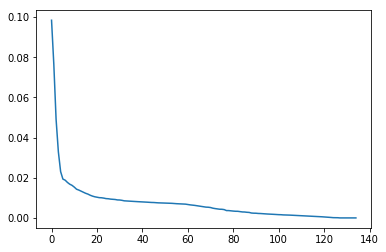

In [77]:
# Investigate the variance accounted for by each principal component.
# Look into explained_variance_ratio of the PCA object.
plt.plot(pca.explained_variance_ratio_)

(array([ 111.,   19.,    1.,    1.,    1.,    0.,    0.,    1.,    0.,    1.]),
 array([  4.78993709e-30,   9.84477535e-03,   1.96895507e-02,
          2.95343261e-02,   3.93791014e-02,   4.92238768e-02,
          5.90686521e-02,   6.89134275e-02,   7.87582028e-02,
          8.86029782e-02,   9.84477535e-02]),
 <a list of 10 Patch objects>)

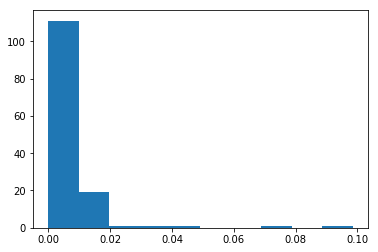

In [78]:
plt.hist(pca.explained_variance_ratio_)

> Visually, it seems that after 20 components the explained_variance_ratio has less significance. 

In [79]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_20 = PCA(n_components = 20)
azdias_pca_array = pca_20.fit_transform(azdias_imp_scaled)

component_cols = pd.DataFrame(azdias_pca_array).columns
component_feature_mapping = dict(zip(component_cols, azdias_imp_scaled.columns))

In [80]:
azdias_pca = pd.DataFrame(azdias_pca_array).rename(component_feature_mapping, axis=1)

In [81]:
azdias_pca.shape

(780153, 20)

In [82]:
for column in azdias_pca.columns.sort_values():
    print(column)

ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_UNAUFFAELLIGER
FINANZ_VORSORGER
GREEN_AVANTGARDE
HEALTH_TYP
RETOURTYP_BK_S
SEMIO_ERL
SEMIO_FAM
SEMIO_KULT
SEMIO_LUST
SEMIO_MAT
SEMIO_RAT
SEMIO_REL
SEMIO_SOZ
SEMIO_VERT


### Discussion 2.2: Perform Dimensionality Reduction

When initially looking at PCA, I setup the model with no parameters. This allowed me to look at all 135 features. When investigating using the explained_variance_ratio_ attribute, I was able to see that after 20 features, the difference in explained variance did not make as many significant changes. I refitted the model with n_components set to 20 and recreated my DataFrame with those features.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [96]:
df_weight = pd.DataFrame(pca_20.components_.T, columns = azdias_pca.columns)
df_weight.iloc[2]

ALTERSKATEGORIE_GROB    -0.207951
ANREDE_KZ                0.073836
FINANZ_MINIMALIST        0.135102
FINANZ_SPARER            0.022487
FINANZ_VORSORGER         0.111906
FINANZ_ANLEGER          -0.063103
FINANZ_UNAUFFAELLIGER   -0.098233
FINANZ_HAUSBAUER        -0.035621
GREEN_AVANTGARDE        -0.029394
HEALTH_TYP              -0.010888
RETOURTYP_BK_S           0.008036
SEMIO_SOZ               -0.068731
SEMIO_FAM               -0.045737
SEMIO_REL                0.042455
SEMIO_MAT               -0.007976
SEMIO_VERT              -0.040669
SEMIO_LUST               0.058567
SEMIO_ERL               -0.082423
SEMIO_KULT               0.013681
SEMIO_RAT               -0.012574
Name: 2, dtype: float64

In [97]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weights(component):
    df = pd.DataFrame(pca_20.components_.T, columns = azdias_pca.columns)
    print('Principal Component: ', df.columns[component])
    return df_weight.iloc[component].sort_values(ascending=False)

In [98]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(0)

Principal Component:  ALTERSKATEGORIE_GROB


ANREDE_KZ                0.233721
SEMIO_VERT               0.056359
SEMIO_MAT                0.046397
FINANZ_UNAUFFAELLIGER    0.038011
FINANZ_HAUSBAUER         0.037527
SEMIO_ERL                0.036166
GREEN_AVANTGARDE         0.029576
FINANZ_MINIMALIST        0.022593
FINANZ_VORSORGER         0.020807
SEMIO_KULT               0.016714
HEALTH_TYP               0.016393
FINANZ_ANLEGER           0.008937
RETOURTYP_BK_S           0.005702
SEMIO_LUST              -0.006725
SEMIO_FAM               -0.011310
SEMIO_RAT               -0.012079
FINANZ_SPARER           -0.038717
SEMIO_SOZ               -0.057829
ALTERSKATEGORIE_GROB    -0.110270
SEMIO_REL               -0.170828
Name: 0, dtype: float64

In [99]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(1)

Principal Component:  ANREDE_KZ


FINANZ_SPARER            0.064241
SEMIO_REL                0.056267
ANREDE_KZ                0.043510
FINANZ_UNAUFFAELLIGER    0.023485
RETOURTYP_BK_S           0.020182
HEALTH_TYP               0.014940
SEMIO_KULT               0.012532
ALTERSKATEGORIE_GROB     0.010687
FINANZ_ANLEGER           0.009454
SEMIO_LUST               0.008688
SEMIO_SOZ                0.006832
SEMIO_MAT                0.001452
SEMIO_RAT               -0.006511
FINANZ_VORSORGER        -0.016643
SEMIO_ERL               -0.019490
FINANZ_HAUSBAUER        -0.020374
GREEN_AVANTGARDE        -0.022096
SEMIO_VERT              -0.035331
SEMIO_FAM               -0.068891
FINANZ_MINIMALIST       -0.356929
Name: 1, dtype: float64

In [100]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(2)

Principal Component:  FINANZ_MINIMALIST


FINANZ_MINIMALIST        0.135102
FINANZ_VORSORGER         0.111906
ANREDE_KZ                0.073836
SEMIO_LUST               0.058567
SEMIO_REL                0.042455
FINANZ_SPARER            0.022487
SEMIO_KULT               0.013681
RETOURTYP_BK_S           0.008036
SEMIO_MAT               -0.007976
HEALTH_TYP              -0.010888
SEMIO_RAT               -0.012574
GREEN_AVANTGARDE        -0.029394
FINANZ_HAUSBAUER        -0.035621
SEMIO_VERT              -0.040669
SEMIO_FAM               -0.045737
FINANZ_ANLEGER          -0.063103
SEMIO_SOZ               -0.068731
SEMIO_ERL               -0.082423
FINANZ_UNAUFFAELLIGER   -0.098233
ALTERSKATEGORIE_GROB    -0.207951
Name: 2, dtype: float64

In [101]:
print
feat_info[feat_info['attribute'] == 'ANREDE_KZ']

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1, 0]"


### Discussion 2.3: Interpret Principal Components

For the first principal component, ALTERSKATEGORIE_GROB (estimated age based on name), the most prominent positive signed feature is ANREDE_KZ (gender), and the most prominent negative signed feature is SEMIO_REL (affinity for relgious). The positive correlation between ALTERSKATEGORIE_GROB and ANREDE_KZ doesn't appear to have a meaningful way to interpret the coorelation. The negative coorelation between ALTERSKATEGORIE_GROB and SEMIO_REL could mean that an increase in age shows a decrease in their affinity to be religious.

For the second principal component, ANREDE_KZ (gender), the most prominent positive signed feature is FINANZ_SPARER (financial trait of money-saver), and the most prominent negative signed feature is FINANZ_MINIMALIST (financial trait of low financial interest). The positive coorelation between ANREDE_KZ and FINANZ_SPARER could mean that one gender has a higher affinity for saving money. The negative coorelation between ANREDE_KZ and FINANZ_MINIMALIST drives the same line of thinking as ANREDE_KZ and FINANZ_SPARER; where one gender has a higher affinity of not caring about their finances.

For the third principal component, FINANZ_MINIMALIST (financial trait of low financial interest), the most prominent positive signed feature is FINANZ_MINIMALIST, and the most prominent negative signed feature is ALTERSKATEGORIE_GROB (estimated age based on name). The positive correlation FINANZ_MINIMALIST has with itself seems to be straight forward, although I was shocked to see it listed like this, as it would be a very linear relationship. The negative correlation between FINANZ_MINIMALIST and ALTERSKATEGORIE_GROB could mean that higher age groups (assumptions) care more about their finances that lower age groups.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

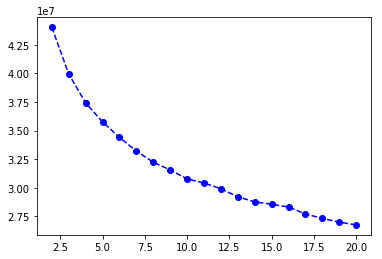

In [100]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
from sklearn.cluster import KMeans


scores = []
centers = list(range(2, 21))

for i in centers:
    model = KMeans(n_clusters=i)
    model_fit = model.fit(azdias_pca)
    scores.append(np.abs(model_fit.score(azdias_pca)))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b')

In [104]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model = KMeans(n_clusters=13)
model.fit(azdias_pca)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Discussion 3.1: Apply Clustering to General Population

In order to choose how many clusters worked best for this data, I created a scree plot that ranged from 2-20 clusters. After visually analyzing the scree plot, it seems that after 13 clusters, there is not as much benefit per added cluster.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [105]:
# Load in the customer demographics data.
customers_df = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [106]:
customers_df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [107]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers_df)

Cleaning DataFrame...
Replacing missing data for each feature with np.nan...
3112918
Removing features with more than 30% data missing...
Removing rows missing more than 10 features...
Removing features that will not be used in analysis...


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Converting OST_WEST_KZ to numeric binary...
One hot encoding features...
Feature engineering...
Dropping additional features...
DataFrame cleaned


In [112]:
# Applying Imputer to handle np.nan.
imp = Imputer(missing_values=np.nan, strategy='most_frequent')
customers_imputed = pd.DataFrame(data=imp.fit_transform(customers_cleaned), index=customers_cleaned.index, columns=customers_cleaned.columns)

In [113]:
customers_imputed.isna().sum(axis=1).sum()

0

In [114]:
# Standardizing data with StandardScaler
customers_standardized = pd.DataFrame(scaler.fit_transform(customers_imputed), columns = customers_imputed.columns)

In [115]:
customers_standardized.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_INTL_2015_WEALTH_1.0,CAMEO_INTL_2015_WEALTH_2.0,CAMEO_INTL_2015_WEALTH_3.0,CAMEO_INTL_2015_WEALTH_4.0,CAMEO_INTL_2015_WEALTH_5.0,CAMEO_INTL_2015_FAMILY_1.0,CAMEO_INTL_2015_FAMILY_2.0,CAMEO_INTL_2015_FAMILY_3.0,CAMEO_INTL_2015_FAMILY_4.0,CAMEO_INTL_2015_FAMILY_5.0
0,0.886637,-0.776965,1.000000,-0.801149,0.820488,-0.847979,-0.407296,-0.680853,1.312832,-1.445365,...,1.939103,-0.517259,-0.277062,-0.422884,-0.31844,-0.361622,-0.280085,2.602203,-0.597713,-0.429815
1,0.886637,-0.776965,1.000000,-0.801149,0.820488,-0.847979,0.223021,-0.680853,-0.761712,-1.445365,...,-0.515702,-0.517259,-0.277062,-0.422884,-0.31844,-0.361622,-0.280085,-0.384290,-0.597713,-0.429815
2,0.886637,1.287059,1.000000,-0.801149,0.820488,-0.847979,0.853339,1.062295,1.312832,0.052027,...,-0.515702,-0.517259,3.609305,-0.422884,-0.31844,-0.361622,-0.280085,-0.384290,1.673044,-0.429815
3,0.886637,-0.776965,1.000000,-0.801149,0.820488,-0.259026,-1.037614,-0.680853,-0.761712,0.052027,...,-0.515702,1.933269,-0.277062,-0.422884,-0.31844,-0.361622,-0.280085,-0.384290,1.673044,-0.429815
4,-0.051252,-0.776965,-0.930079,-0.801149,-0.184171,0.918880,1.483656,-0.680853,-0.761712,1.549419,...,-0.515702,-0.517259,-0.277062,2.364713,-0.31844,2.765320,-0.280085,-0.384290,-0.597713,-0.429815


In [126]:
azdias_pca_columns = azdias_pca.columns.tolist()
customers_cleaned = customers_standardized.drop(columns=[col for col in customers_standardized if col not in azdias_pca_columns])


In [145]:
list1 = customers_cleaned.columns.tolist()
list2 = azdias_pca.columns.tolist()
list1.sort()
list2.sort()
def difference(list1, list2): 
    return (list(set(list1) - set(list2))) 
print(difference(list1, list2))

[]


In [142]:
# Applying PCA
customers_pca = pca_20.transform(customers_cleaned)

ValueError: operands could not be broadcast together with shapes (191652,20) (135,) 

In [ ]:
# Using predict with kmeans model.
customers_pred = kmeans.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.